# UpPMaBoSS notebook for the cell fate model

This notebook shows an example of the use of UpPMaBoSS. 
UpPMaBoSS computes the evolution and the dynamics of a population of cells taking into account both their intracellular and intercellular regulations.

Three files related to the logical model used for the analysis are required:
==> the model files: *CellFateModel.bnd* and *CellFateModel.cfg*. 
==> the configuration file for UpPMaBoSS: *CellFate.upp* 

In [1]:
# Set up working environment
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import pandas as pd
import numpy as np
import os

import maboss
import umbs


# Set seaborn style and create color maps: white-black scale and blue-light-red for ratios
sns.set_style("white")
colormap_scale = sns.light_palette("black", as_cmap=True)
colormap_ratios = sns.diverging_palette(240, 0, center='light', as_cmap=True)

# Shortcut to save figures with a common pattern and format
def save_figure(figure, title):
    figure.savefig("figure_%s.pdf" % title, bbox_inches="tight")

In [2]:
# Set up the required files
bnd_file ="CellFateModel.bnd"
cfg_WT = "CellFateModel.cfg"
upp_file = "CellFate.upp"

# MaBoSS simulation of the wild type model

In [3]:
# Load the Wild-Type model
model_WT = maboss.load(bnd_file, cfg_WT)

# Set some parameters in the cfg file: "max_time" 
# and select the variables considered to be internal (not appearing in the resulting csv file)
# here, only the outputs will appear: Death, Division and NFkB
model_48h = maboss.copy_and_update_parameters(model_WT, {'max_time':48})
for name in "mcIAP mXIAP mROS NonACD Apoptosis Survival TNF ATP FADD cIAP FASL TNFR DISC_TNF DISC_FAS RIP1 RIP1ub RIP1K IKK CASP8 BAX BCL2 ROS MPT MOMP SMAC Cyt_c XIAP apoptosome CASP3 cFLIP".split(' '):
    model_48h.network[name].is_internal = True


In [4]:
model_48h.network.set_output(('Death','Division','NFkB'))
run_48h = model_48h.run()

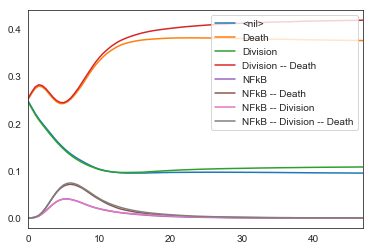

In [5]:
# Plot the results of the WT simulation
run_48h.get_states_probtraj().plot()

# Note that the model state <nil> means that none of the external variables are ON. 

# UpPMaBoSS simulations

## Wild Type simulations with and without the feedback

In [6]:
# Run UpPMaBoSS on the WT model and collect population ratios
# A folder named "WT" "is created with the 16 runs
run_WT = umbs.UpP_MaBoSS(model_WT, upp_file, 'WT')
pop_ratios_WT = run_WT.get_population_ratios('NFkB -> TNF')

In [7]:
# Create a variant without the population feedback NFkB -> TNF
model_NoFB = maboss.copy_and_update_parameters(model_WT, {'$ProdTNF_NFkB': 0})

# Run UpPMaBoSS for the model without population feedback
# A folder named "NoFB" "is created with the 16 runs
run_NoFB = umbs.UpP_MaBoSS(model_NoFB, upp_file, 'NoFB')
pop_ratios_NoFB = run_NoFB.get_population_ratios('No NFkB -> TNF')

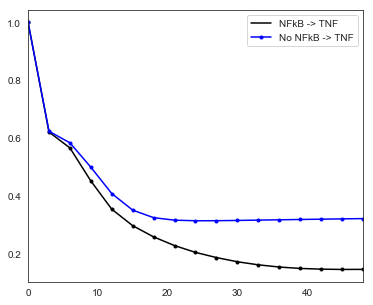

In [8]:
# Plot population ratio with/without population feedback
# A figure is saved in the folder with the name: "figure_ratios.pdf"
figure = plt.figure(figsize = (6,5))
pop_ratios_WT.plot(style='.-k', legend=True)
pop_ratios_NoFB.plot(style='.-b', legend=True)
save_figure(figure, 'ratios')

## Simulations with and without TNF treatments

In [9]:
# Create a model with no TNF (TNF OFF)
model_noTNF = model_WT.copy()
model_noTNF.network.set_istate('TNF', [1,0])

# Run UpPMaBoSS for the model with no TNF
# A folder named "noTNF" "is created with the 16 runs
run_noTNF = umbs.UpP_MaBoSS(model_noTNF, upp_file, 'noTNF')
pop_ratios_noTNF = run_noTNF.get_population_ratios('No pulse TNF')

In [10]:
# Create a model for a second treatment of TNF
model_reTNF = maboss.copy_and_update_parameters(model_WT, {'$TNF_induc': 20})

# Run UpPMaBoSS for the second treatment of TNF after a WT run with TNF ON
# A folder named "reTNF" "is created with the 16 runs
run_reTNF = umbs.UpP_MaBoSS(model_reTNF, upp_file, 'reTNF', previous_run=run_WT)
pop_ratios_reTNF = run_reTNF.get_population_ratios('TNF')

# Run UpPMaBoSS for a treatment of TNF after a run with no TNF (where TNF was initially OFF)
# A folder named "noTNF_reTNF" "is created with the 16 runs
run_noTNF_reTNF = umbs.UpP_MaBoSS(model_reTNF, upp_file, 'noTNF_reTNF', previous_run=run_noTNF)
pop_ratios_noTNF_reTNF = run_noTNF_reTNF.get_population_ratios('TNF')

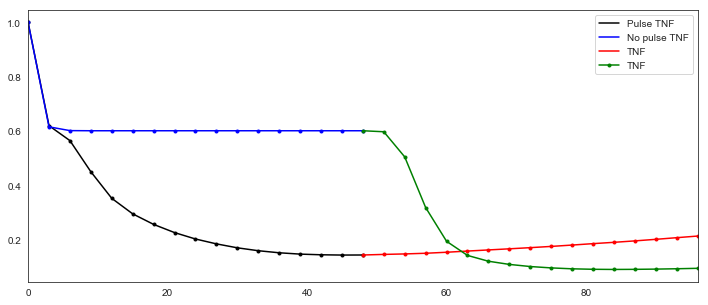

In [11]:
# Plot population ratios for a second treatment of TNF with or without the initial TNF stimulation
# A figure "figure_two_steps_ratios.pdf" is saved
figure = plt.figure(figsize = (12,5))
pop_ratios_WT.name = "Pulse TNF"
pop_ratios_WT.plot(style='.-k', legend=True)
pop_ratios_noTNF.plot(style='.-b', legend=True)
pop_ratios_reTNF.plot(style='.-r', legend=True)
pop_ratios_noTNF_reTNF.plot(style='.-g', legend=True)
save_figure(figure, 'two_steps_ratios')

# Study TNF resistance

In [12]:
workdir = 'TNF_sensitivity'

def tnf_effect(workdir, model, name, df=None):
    "explore the effect of TNF in a given model variant"
    
    if df is None:
        df = pd.DataFrame()
    
    # Configuration of the model variants corresponding to combinations of (no) initial and secondary treatments
    model_pulse = model
    model_nopulse = model.copy()
    model_nopulse.network.set_istate('TNF', [1,0])
    
    model_tnf = maboss.copy_and_update_parameters(model, {'$TNF_induc':20})
    model_notnf = model
    
    # storage of all runs
    runs = {}
    
    # Simulations of no initial TNF pulse, then with or without constitutive TNF
    run_no_pulse = umbs.UpP_MaBoSS(model_nopulse, upp_file, os.path.join(workdir, name, 'nopulse'))
    runs['No pulse TNF, no TNF'] = umbs.UpP_MaBoSS(model_notnf, upp_file, os.path.join(workdir, name, 'noPulse_noTNF'), previous_run=run_no_pulse)
    runs['No pulse TNF, TNF'] = umbs.UpP_MaBoSS(model_tnf, upp_file, os.path.join(workdir, name, 'noPulse_TNF'), previous_run=run_no_pulse)

    # Simulations of initial TNF pulse, then with or without constitutive TNF
    run_pulse = umbs.UpP_MaBoSS(model_pulse, upp_file, os.path.join(workdir, name, 'pulse'))
    runs['Pulse TNF, no TNF'] = umbs.UpP_MaBoSS(model_notnf, upp_file, os.path.join(workdir, name, 'pulse_noTNF'), previous_run=run_pulse)
    runs['Pulse TNF, TNF'] = umbs.UpP_MaBoSS(model_tnf, upp_file, os.path.join(workdir, name, 'pulse_TNF'), previous_run=run_pulse)

    # Collection of population ratios
    for key in runs:
        pop_ratios = runs[key].get_population_ratios(key)
        if key not in df.columns:
            df[key] = pd.Series(name=name, dtype=np.float)
        df.at[name, key] = pop_ratios.iloc[-1]

    return df

In [13]:
# TNF sensitivity for the WT model
ratios = tnf_effect(workdir, model_WT, 'WT')

# List of all mutations to test
# Here all species will be mutated except for the output nodes
excluded = set( ( 'NonACD', 'Apoptosis', 'Survival', 'Division', 'Death', 'TNF', 'apoptosome') )
nodes = [ n for n in model_WT.network.names if n not in excluded ]
nodes.sort()


# TNF sensitivity for each mutant of the model
for mutant_node in nodes:
    print(mutant_node, end=' ')
    mut_model = maboss.copy_and_mutate(model_WT, [mutant_node], 'OFF')
    tnf_effect(workdir, mut_model, '%s' % mutant_node, ratios)

ATP 

BAX 

BCL2 

CASP3 

CASP8 

Cyt_c 

DISC_FAS 

DISC_TNF 

FADD 

FASL 

IKK 

MOMP 

MPT 

NFkB 

RIP1 

RIP1K 

RIP1ub 

ROS 

SMAC 

TNFR XIAP 

cFLIP 

cIAP 

mROS 

mXIAP 

mcIAP 

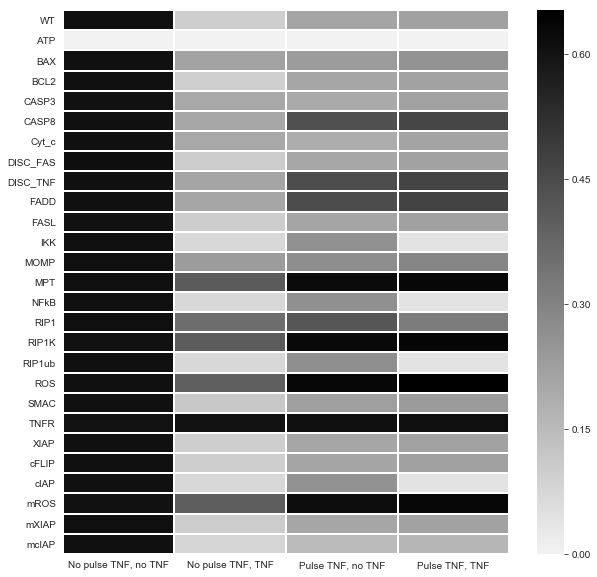

In [14]:
# Plot the TNF sensitivity results for the WT condition and for all mutants 
figure = plt.figure(figsize = (10,10))
sns.heatmap(ratios, annot=False, cmap=colormap_scale, linewidths=1)
save_figure(figure, 'heatmap')

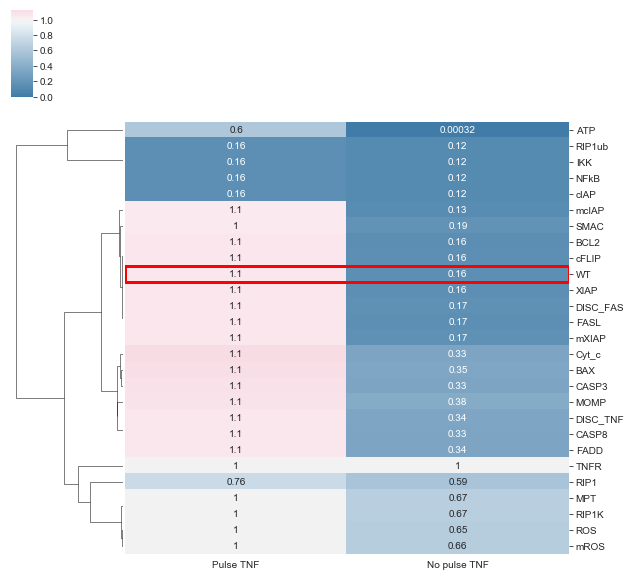

In [15]:
# More abstract summary: cluster of the ratios of ratios
ratios_ratios = pd.DataFrame()
ratios_ratios['Pulse TNF'] = ratios['Pulse TNF, TNF'] / ratios['Pulse TNF, no TNF']
ratios_ratios['No pulse TNF'] = ratios['No pulse TNF, TNF'] / ratios['No pulse TNF, no TNF']

figure = sns.clustermap(ratios_ratios, annot=True, cmap=colormap_ratios, center=1, col_cluster=False)

# Add a rectangle around the WT row
wt_index = figure.dendrogram_row.reordered_ind.index(0)
figure.ax_heatmap.add_patch(Rectangle((0, wt_index), 2, 1, fill=False, edgecolor='red', lw=3))

save_figure(figure, 'cluster')